In [1]:
import json, os
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('msd_taste_profile_cleaned.json', 'r') as f:
    taste_profile_raw = json.load(f)

with open('msd_subset_audio_features_normalized.json', 'r') as f:
    merged_features_processed = json.load(f)
    
with open('msd_average_user_profiles.json', 'r') as f:
    average_user_profiles = json.load(f)
    
with open('msd_user_setlists.json', 'r') as f:
    user_setlists = json.load(f)

In [3]:
def dict_euclidean_distance(a, b):
    return np.linalg.norm(np.array(list(a.values())) - np.array(list(b.values())))

def dict_manhtattan_distance(a, b):
    return np.sum(np.abs(np.array(list(a.values())) - np.array(list(b.values()))))

# Define a user's rating of a track as the number of times they listened to it
# If they haven't listened to it, define rating as the similarity (i.e. inverse distance) between the user's average profile and the track's features
def user_rating(user_id, track_id, distance_func: callable=dict_euclidean_distance):
    if track_id in user_setlists[user_id]:
        return user_setlists[user_id][track_id]
    else:
        user_avg_features = average_user_profiles[user_id]
        track_features = merged_features_processed[track_id]
        
        return 1 / (1 + distance_func(user_avg_features, track_features))        

In [4]:
def pearson_user_sim(user_id1, user_id2):
    combined_songs = set([*user_setlists[user_id1].keys(), *user_setlists[user_id2].keys()])
    n_songs = len(combined_songs)
    
    user1_ratings = np.zeros(n_songs)
    user2_ratings = np.zeros(n_songs)
    
    for i, song in enumerate(combined_songs):
        user1_ratings[i] = user_rating(user_id1, song)
        user2_ratings[i] = user_rating(user_id2, song)
    
    user1_ratings[:] -= np.mean(user1_ratings)
    user2_ratings[:] -= np.mean(user2_ratings)
    
    num = np.dot(user1_ratings, user2_ratings)
    den = np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings)
    
    if num == 0 and den == 0:
        return 1
    
    return num / den

def cosine_user_sim(user_id1, user_id2):
    combined_songs = set([*user_setlists[user_id1].keys(), *user_setlists[user_id2].keys()])
    n_songs = len(combined_songs)
    
    user1_ratings = np.zeros(n_songs)
    user2_ratings = np.zeros(n_songs)
    
    for i, song in enumerate(combined_songs):
        user1_ratings[i] = user_rating(user_id1, song)
        user2_ratings[i] = user_rating(user_id2, song)
    
    num = np.dot(user1_ratings, user2_ratings)
    den = np.linalg.norm(user1_ratings) * np.linalg.norm(user2_ratings)
    
    if num == 0 and den == 0:
        return 0
    
    return num / den

In [5]:
# Generate user ID to index mapping
userid_to_index = { user_id: i for i, user_id in enumerate(average_user_profiles.keys()) }
index_to_userid = { v: k for k, v in userid_to_index.items() }

In [6]:
RAND_SEED = 916
rand = np.random.default_rng(RAND_SEED)

In [7]:
def simulate_subset(subset_size, rand, neighborhood_sizes, user_sim_func, given_subset=None):
    # Generate random user subset, or use the given one
    if given_subset == None:
        user_subset = rand.choice(len(average_user_profiles), subset_size, replace=False)
    else: 
        user_subset = given_subset
        subset_size = len(user_subset)
    
    print(len(user_subset), subset_size)
    index_subset_mapping = { i: index_to_userid[user_id] for i, user_id in enumerate(user_subset) }
    subset_index_mapping = { v: k for k, v in index_subset_mapping.items() }
    
    print(f'Generating similarity matrix for subset of size {subset_size}...')
    user_similarity = np.full((subset_size, subset_size), -np.inf)
    total_sims = (subset_size * (subset_size - 1)) // 2

    for i, pair in enumerate(combinations(index_subset_mapping, 2)):
        if i % 2500 == 0:
            print(f'{i=}/{total_sims} | {(i/total_sims * 100):.3f}%', end='\r')
        
        user1, user2 = pair
        sim = user_sim_func(index_subset_mapping[user1], index_subset_mapping[user2])
        
        user_similarity[user1][user2] = sim
        user_similarity[user2][user1] = sim
    print()
        
    user_similarity_sorted = np.argsort(user_similarity)
    
    # Uses the similarity matrix to generate neighborhoods of size n
    # This is pretty awful code, but it'll do. Anyways, we're data scientists, not software engineers
    def run_neighborhood_analysis(neighborhood_size):
        print(f'>> Generating neighborhood of size {neighborhood_size}...')
        user_neighborhoods = {}
        
        for i, row in enumerate(user_similarity_sorted):
            user_neighborhoods[index_subset_mapping[i]] = [index_subset_mapping[n] for n in row[-neighborhood_size:]]
            
        def predict_rating(user_id, track_id):
            user_index = subset_index_mapping[user_id]
            neighborhood = user_neighborhoods[user_id]
            
            neighborhood_ratings = [user_rating(neighbor, track_id) for neighbor in neighborhood]
            
            similarities = [user_similarity[user_index][subset_index_mapping[neighbor]] for neighbor in neighborhood]
            
            num = np.dot(similarities, neighborhood_ratings)
            den = np.abs(similarities).sum()
            
            if num == 0 or den == 0:
                return 0

            return num / den
        
        squared_error = 0
        abs_error = 0
        hits = 0
        liked_right = 0
        run_count = 0
        
        print(f'>> Analyzing neighborhood of size {neighborhood_size}...')
        for i, user in enumerate(user_neighborhoods):
            if i % 250 == 0:
                print(f'>> {i=}/{subset_size} | {(i/subset_size * 100):.3f}%', end='\r')
            
            for track in taste_profile_raw[user]:
                run_count += 1
                track_id = track['track']
                
                prediction = predict_rating(user, track_id)
                actual = track['count']
                
                abs_error += np.abs(prediction - actual)
                squared_error += (prediction - actual) ** 2
                
                if round(prediction) == actual:
                    hits += 1
                
                if (prediction >= 1 and actual >= 1) or (prediction < 1 and actual == 0):
                    liked_right += 1

        return user_neighborhoods, squared_error / run_count, abs_error / run_count, hits / run_count, liked_right / run_count
    
    neighborhood_analysis = [run_neighborhood_analysis(n) for n in neighborhood_sizes]
    print()
    
    return user_similarity, subset_index_mapping, index_subset_mapping, neighborhood_analysis

In [8]:
all_tracks = set()

for user, setlist in user_setlists.items():
    all_tracks.update(setlist.keys())
    
all_tracks = list(all_tracks)
n_tracks = len(all_tracks)
n_tracks

384

In [9]:
# Load in pre-generated list of user-track interactions to evaluate model with
sampled_interactions = pd.read_csv('sampled_interactions.csv')
users = set(sampled_interactions['user'])
n_users = len(users)

subset_indices = [userid_to_index[user] for user in users]
n_users, subset_indices[:5]

(1000, [311, 875, 457, 395, 121])

In [10]:
# Generate negative samples, and append them to the list of interactions
n_samples = 1

for i, user in enumerate(users):
    if i % 250 == 0:
        print(f'{i}/{n_users} | {i/n_users * 100:.2f}%', end='\r')
        
    user_tracks = set([t['track'] for t in taste_profile_raw[user]])
    negative_choice_pool = [ t for t in all_tracks if t not in user_tracks ]
    
    negative_choices = rand.choice(negative_choice_pool, size=n_samples, replace=False)
    taste_profile_raw[user].extend([{'track': t, 'count': 0} for t in negative_choices])

In [11]:
len(set(sampled_interactions['track']))

384

In [12]:
# Smaller subset size than in the report due to the smaller amount of users in this data subset
subset_sizes = [1000]
neighborhood_sizes = [2, 3, 5, 10, 25, 50, 100, 250, 500, 750]

results = {}

for size in subset_sizes:
    results[size] = simulate_subset(size, rand, [s for s in neighborhood_sizes if s < size], cosine_user_sim, subset_indices[:size])

1000 1000
Generating similarity matrix for subset of size 1000...


i=497500/499500 | 99.600%
>> Generating neighborhood of size 2...
>> Analyzing neighborhood of size 2...
>> Generating neighborhood of size 3...
>> Analyzing neighborhood of size 3...
>> Generating neighborhood of size 5...
>> Analyzing neighborhood of size 5...
>> Generating neighborhood of size 10...
>> Analyzing neighborhood of size 10...
>> Generating neighborhood of size 25...
>> Analyzing neighborhood of size 25...
>> Generating neighborhood of size 50...
>> Analyzing neighborhood of size 50...
>> Generating neighborhood of size 100...
>> Analyzing neighborhood of size 100...
>> Generating neighborhood of size 250...
>> Analyzing neighborhood of size 250...
>> Generating neighborhood of size 500...
>> Analyzing neighborhood of size 500...
>> Generating neighborhood of size 750...
>> Analyzing neighborhood of size 750...
>> i=750/1000 | 75.000%


/tmp/ipykernel_5707/192862313.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


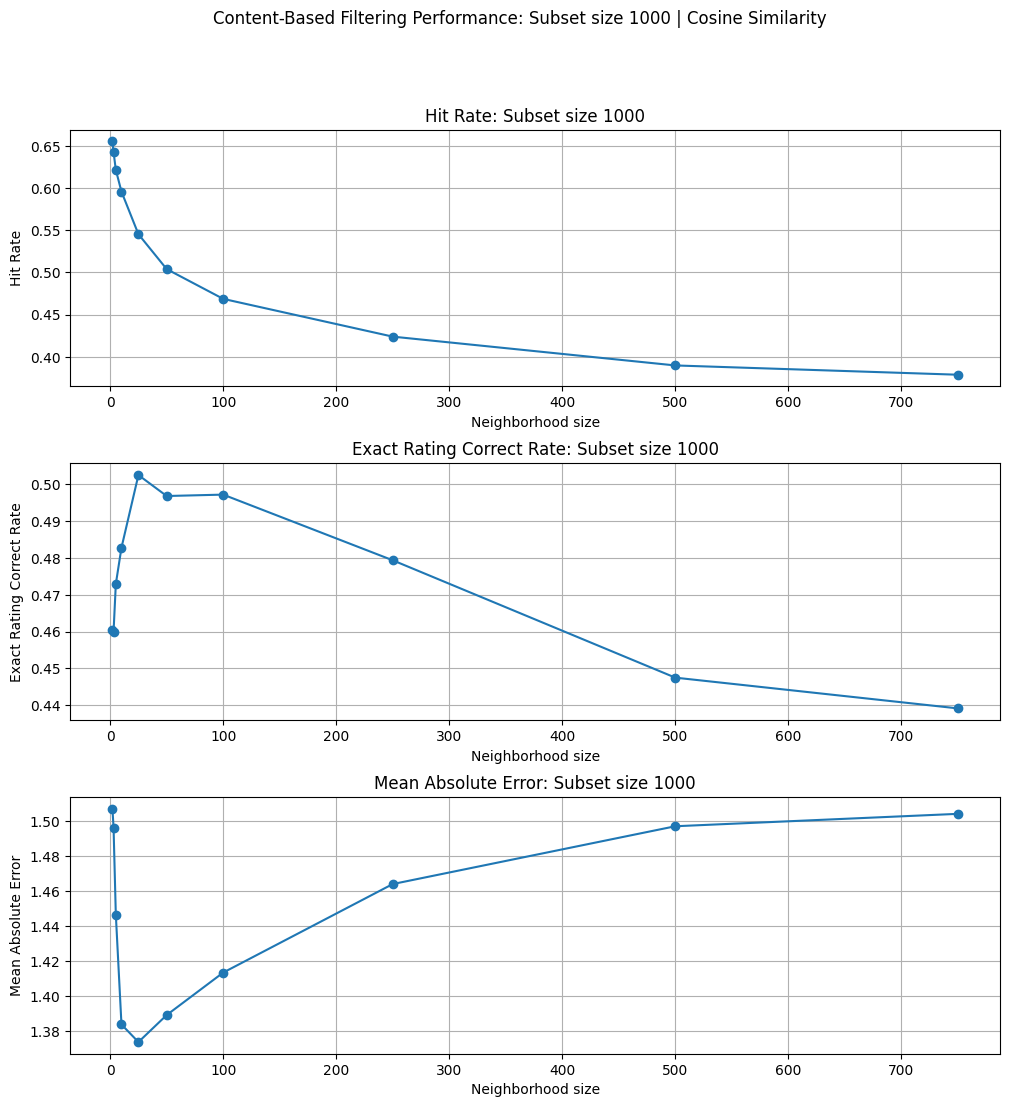

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12), gridspec_kw={'hspace': 0.3})

labels=['Hit Rate', 'Exact Rating Correct Rate', 'Mean Absolute Error', ]
index_num = [4, 3, 2]
for axnum, ax in enumerate(axs.flatten()):
    index = index_num[axnum]
    label = labels[axnum]
    size = subset_sizes[0]
    this_neighborhood_sizes = [s for s in neighborhood_sizes if s < size]
    
    ax.plot(this_neighborhood_sizes, [r[index] for r in results[size][3]], marker='o', label=label)
    
    ax.set_title(f'{label}: Subset size {size}')
    ax.set_xlabel('Neighborhood size')
    ax.set_ylabel(label)
    ax.grid(True)

plt.suptitle(f'Content-Based Filtering Performance: Subset size {size} | Cosine Similarity')
plt.tight_layout()
plt.show()

In [14]:
# Functions to load and save a trained collaborative filtering model

USER_SIM_FILE = 'user_similarity'
SUBSET_INDEX_MAPPING_FILE = 'subset_index_mapping'
USER_NEIGHBORHOODS_FILE = 'user_neighborhoods'

def save_model(subset_size, neighborhood_size, destination: str):
    dirname = f'saved_models/{destination}'
    os.mkdir(dirname)
    
    to_save = results[subset_size]
    
    np.save(f'{dirname}/{USER_SIM_FILE}', to_save[0])
    
    with open(f'{dirname}/{SUBSET_INDEX_MAPPING_FILE}.json', 'w') as f:
        json.dump(to_save[1], f)
    
    neighborhood = to_save[3][neighborhood_sizes.index(neighborhood_size)]
    with open(f'{dirname}/{USER_NEIGHBORHOODS_FILE}.json', 'w') as f:
        json.dump(neighborhood[0], f)
        
def load_model(source: str):
    dirname = f'saved_models/{source}'
    sims = np.load(f'{dirname}/{USER_SIM_FILE}.npy')
    
    with open(f'{dirname}/{SUBSET_INDEX_MAPPING_FILE}.json', 'r') as f:
        index_map = json.load(f)
    
    with open(f'{dirname}/{USER_NEIGHBORHOODS_FILE}.json', 'r') as f:
        neighborhoods = json.load(f)
        
    return sims, index_map, neighborhoods

In [16]:
# You may need to create a folder called "saved_models" here in the current directory
save_model(1000, 5, 'subset_final')